In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.colors as mcolors
from matplotlib.transforms import Bbox
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scvi
import scanpy as sc
import itertools
from sklearn.preprocessing import MinMaxScaler
import anndata as an
import scanpy.external as sce
from matplotlib.path import Path
import scipy
import scipy.sparse as sp
import gget
import time
import sklearn
import torch
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.manifold import MDS
from brokenaxes import brokenaxes
import sklearn.metrics as sm
from adjustText import adjust_text

from importlib import reload

# local imports
import utils as ut
import plotting as plt2

sc.settings.verbosity = 3 

# Load Data

In [2]:
fpath = "/scratch/indikar_root/indikar1/shared_data/scanvi_model_minimal/imputed_adata/hvg13000.h5ad"
adata = sc.read_h5ad(fpath)
adata.X = adata.layers['scanvi_counts'].copy()

# make counts out of 10000
scale_expression  = 1e4
adata.layers['scaled_scanvi'] = np.log1p(adata.layers['scanvi_counts'] * scale_expression)

sc.tl.embedding_density(adata, basis='umap')

sc.logging.print_memory_usage()
print(adata)

computing density on 'umap'
--> added
    'umap_density', densities (adata.obs)
    'umap_density_params', parameter (adata.uns)
Memory usage: current 10.97 GB, difference +10.97 GB
AnnData object with n_obs × n_vars = 61115 × 13000
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'batch', 'umap_density'
    uns: 'neighbors', 'pca', 'umap', 'umap_density_params'
    obsm: 'X_harmony', 'X_pca', 'X_scanorama', 'X_scanvi', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scanvi_counts', 'scaled_scanvi'
    obsp: 'connectivities', 'distances'


# Load gene sets

In [3]:
reload(ut)
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

[x for x in features.columns if 'hemato' in x.lower()]

# pathway = 'Hematopoietic Stem Cells'
pathway = 'Fibroblasts'
query_genes = list(features[features[pathway]].index)
print(len(query_genes))
query_genes[:10]

232


['RARRES2',
 'CELA1',
 'LUM',
 'PRRX1',
 'SCARA5',
 'COL1A1',
 'COL5A2',
 'COL5A1',
 'FNDC1',
 'COL12A1']

In [4]:
fpath = "../resources/scenic.tf_list.txt"
tf_list = [x.strip() for x in open(fpath)]
tf_list[:10]

['ZNF354C',
 'KLF12',
 'ZNF143',
 'ZIC2',
 'ZNF274',
 'SP2',
 'ZBTB7A',
 'BCL6B',
 'ZBTB49',
 'ZIC1']

# Filter dataset

In [5]:
mask = (adata.obs['dataset'] != 'pellin')
adata = adata[mask, :].copy()

mask = (adata.obs['dataset'] != 'tabula_sapiens')
adata = adata[mask, :].copy()

adata

AnnData object with n_obs × n_vars = 33748 × 13000
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'batch', 'umap_density'
    uns: 'neighbors', 'pca', 'umap', 'umap_density_params'
    obsm: 'X_harmony', 'X_pca', 'X_scanorama', 'X_scanvi', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scanvi_counts', 'scaled_scanvi'
    obsp: 'connectivities', 'distances'

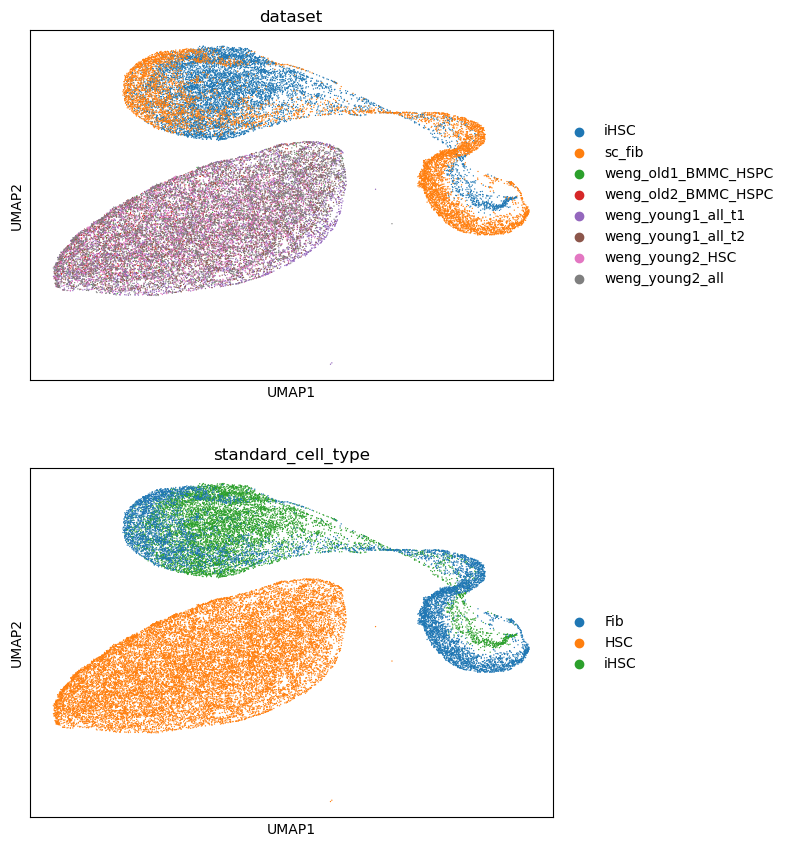

In [6]:
sc.pl.umap(
    adata,
    color=[
        'dataset',
        'standard_cell_type',
    ],
    ncols=1,
)

In [7]:
# break

# aggregate distances

In [8]:
aggdata = sc.get.aggregate(
    adata,
    by='standard_cell_type',
    func='mean',
    layer='scaled_scanvi'
)

aggdata.X = aggdata.layers['mean'].copy()

df = aggdata.to_df()
df = df.T
df.head()

,Fib,HSC,iHSC
gene_name,,,
A1BG,0.817040,0.285857,1.146238
A2M,0.365591,0.413591,0.676883
A2ML1,1.482582,0.062655,0.987651
A3GALT2,0.220516,0.066727,0.268357
AACS,0.029266,0.168479,0.058479


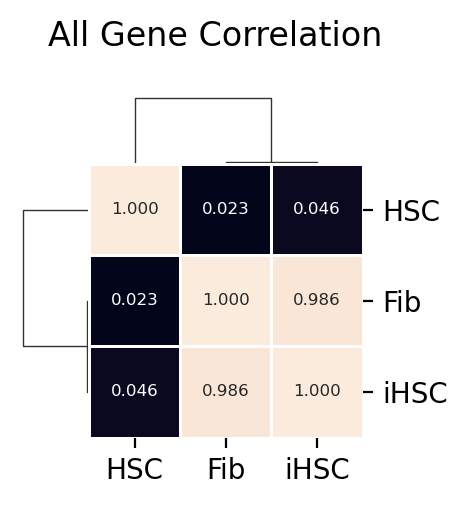

In [9]:
A = df.corr()
n = A.shape[0]
plot_n = n * 0.75

plt.rcParams['figure.dpi'] = 200

sns.clustermap(
    A, 
    square=True,
    lw=1,
    figsize=(plot_n, plot_n),
    annot=True,
    cbar_pos=None,
    fmt=".3f",
    annot_kws={'fontsize' : 6},
    cbar_kws={'shrink' : 0.45},
)
plt.suptitle('All Gene Correlation', y=1.1)

plt.gca().tick_params(axis='y', rotation=0)

# Distances

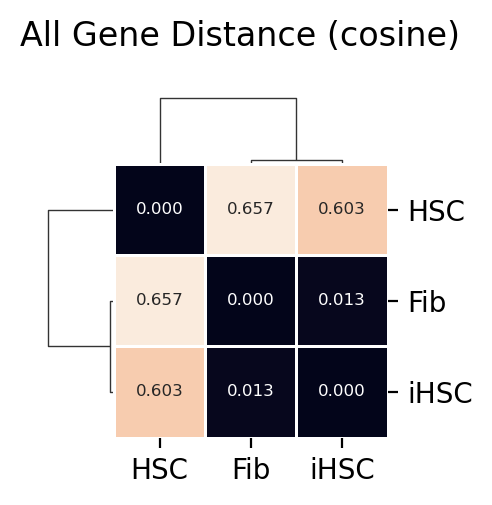

In [10]:
metric = 'cosine'
A = sm.pairwise_distances(
    df.T, 
    metric=metric,
)

# Convert to a DataFrame
A = pd.DataFrame(
    A, 
    index=df.columns,
    columns=df.columns,
)

n = A.shape[0]
plot_n = n * 0.75

plt.rcParams['figure.dpi'] = 200

sns.clustermap(
    A, 
    square=True,
    lw=1,
    figsize=(plot_n, plot_n),
    annot=True,
    cbar_pos=None,
    fmt=".3f",
    annot_kws={'fontsize' : 6},
    cbar_kws={'shrink' : 0.45},
)
plt.suptitle(f'All Gene Distance ({metric})', y=1.1)

plt.gca().tick_params(axis='y', rotation=0)

# Load annotations and filter

In [11]:
# load the obs annotations
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/obs/merged_scfib_obs.csv"
obs = pd.read_csv(fpath)

obs['new_cluster_str'] = obs['new_cluster'].apply(lambda x: f"F{int(x) + 1}")

cluster_map = dict(zip(obs['cell_id'].values, obs['cluster_str'].values))
new_cluster_map = dict(zip(obs['cell_id'].values, obs['new_cluster_str'].values))

adata.obs['cluster_str'] = adata.obs.index.map(cluster_map)
adata.obs['new_cluster_str'] = adata.obs.index.map(new_cluster_map)

# Filter cluster C6
mask = (adata.obs['cluster_str'] == 'C6') & (adata.obs['dataset'] == 'iHSC')
adata = adata[~mask, :].copy()

# filter out low-quality FB clusters
mask = (adata.obs['new_cluster_str'].isin(['F7', 'F8'])) & (adata.obs['dataset'].isin(['iHSC', 'sc_fib']))
adata = adata[~mask, :].copy()

# filter out tabula sapiens

print(adata)
print()
adata.obs['cluster_str'].value_counts()

AnnData object with n_obs × n_vars = 33176 × 13000
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'batch', 'umap_density', 'cluster_str', 'new_cluster_str'
    uns: 'neighbors', 'pca', 'umap', 'umap_density_params', 'dataset_colors', 'standard_cell_type_colors'
    obsm: 'X_harmony', 'X_pca', 'X_scanorama', 'X_scanvi', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scanvi_counts', 'scaled_scanvi'
    obsp: 'connectivities', 'distances'



cluster_str
C1    3834
C2    1650
C3    1497
C4     558
C5      20
Name: count, dtype: int64

# annotate further

In [12]:
# sort the cells by type
sorted_indices = adata.obs['standard_cell_type'].argsort()
adata = adata[sorted_indices, :].copy() 

# establish grouping
adata.obs['group'] = np.where(adata.obs['cluster_str'].isin(['C2', 'C5']), "iHSC-high", "HSC")
adata.obs['group'] = np.where(adata.obs['cluster_str'].isin(['C1', 'C3']), "iHSC-low", adata.obs['group'])
adata.obs['group'] = np.where(adata.obs['cluster_str'] == 'C4', "BJ Fib", adata.obs['group'])
adata.obs['group'] = np.where(adata.obs['dataset'] == 'sc_fib', "BJ Fib", adata.obs['group'])

print(adata.obs['group'].value_counts())
print()

adata.obs['group2'] = adata.obs['cluster_str'].copy()
adata.obs['group2'] = np.where(adata.obs['cell_label'] == 'HSC', 'HSC', adata.obs['group2'])
adata.obs['group2'] = np.where(adata.obs['dataset'] == 'sc_fib', 'Bj Fib', adata.obs['group2'])

print(adata.obs['group2'].value_counts())
print()

group
HSC          18302
BJ Fib        7873
iHSC-low      5331
iHSC-high     1670
Name: count, dtype: int64

group2
HSC       18302
Bj Fib     7315
C1         3834
C2         1650
C3         1497
C4          558
C5           20
Name: count, dtype: int64



... storing 'cluster_str' as categorical
... storing 'new_cluster_str' as categorical
... storing 'group' as categorical
... storing 'group2' as categorical


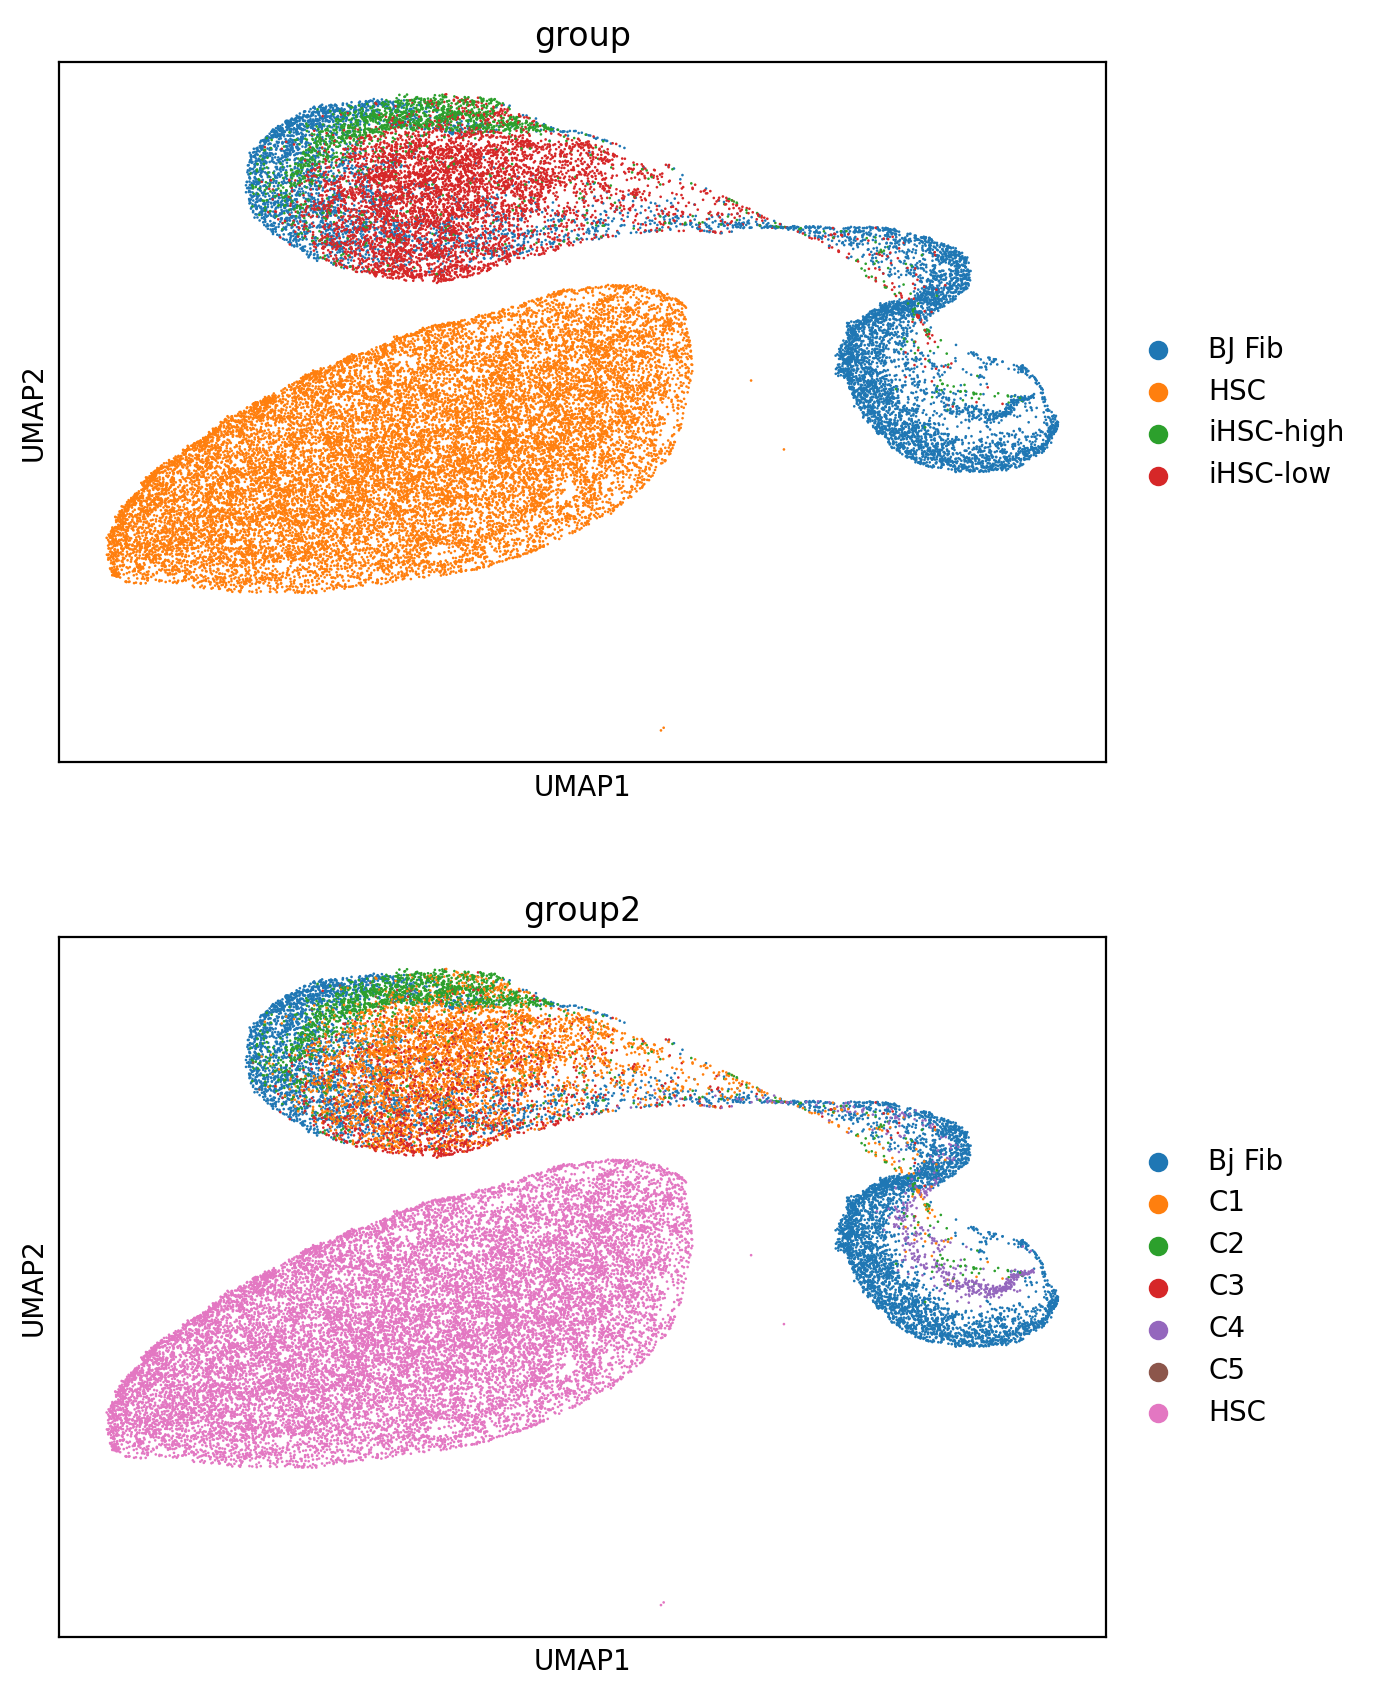

In [13]:
sc.pl.umap(
    adata,
    color=[
        'group',
        'group2',
    ],
    ncols=1,
)

# Aggregate Data

In [14]:
aggdata = sc.get.aggregate(
    adata,
    by='group',
    func='mean',
    layer='scaled_scanvi'
)

aggdata.X = aggdata.layers['mean']
df = aggdata.to_df(layer='mean')
df = df.T
df.head()

,BJ Fib,HSC,iHSC-high,iHSC-low
gene_name,,,,
A1BG,0.820633,0.285857,1.178875,1.164262
A2M,0.368990,0.413591,0.729224,0.686240
A2ML1,1.495368,0.062655,0.906385,0.945237
A3GALT2,0.225254,0.066727,0.271153,0.265548
AACS,0.029844,0.168479,0.065116,0.058406


# MDS

In [15]:
d_func = scipy.spatial.distance.cosine
# d_func = scipy.spatial.distance.euclidean

comps = {
    'hsc_to_bj_fib': ('BJ Fib', 'HSC'),
    'ihsc_high_to_hsc': ('iHSC-high', 'HSC'),
    'ihsc_low_to_hsc': ('iHSC-low', 'HSC'),
    'ihsc_low_to_bj_fib': ('iHSC-low', 'BJ Fib'),
    'ihsc_high_to_bj_fib': ('iHSC-high', 'BJ Fib'),
}

for k, v in comps.items():
    distance = d_func(df[v[0]], df[v[1]])
    print(f"{k} : {distance:.3f}")

hsc_to_bj_fib : 0.653
ihsc_high_to_hsc : 0.595
ihsc_low_to_hsc : 0.607
ihsc_low_to_bj_fib : 0.014
ihsc_high_to_bj_fib : 0.017


In [16]:
def scaler(vector):
  return MinMaxScaler().fit_transform(np.array(vector).reshape(-1, 1)).flatten()

In [17]:
metric = 'cosine'
# metric = 'euclidean'

pdf = df.copy()

A = sm.pairwise_distances(
    pdf.T, 
    metric=metric,
)

# Convert to a DataFrame
A = pd.DataFrame(
    A, 
    index=pdf.columns,
    columns=pdf.columns,
)

print(A.round(3))

mds = MDS(n_components=1, dissimilarity='precomputed')
coordinates = mds.fit_transform(A)

cdf = pd.DataFrame({
    'x' : coordinates[:, 0],
    'x_scaled' : scaler(coordinates[:, 0]),
    'label' : pdf.columns,
})

cdf = cdf.sort_values("x")
cdf = cdf.reset_index(drop=True)
cdf.head()

           BJ Fib    HSC  iHSC-high  iHSC-low
BJ Fib      0.000  0.653      0.017     0.014
HSC         0.653  0.000      0.595     0.607
iHSC-high   0.017  0.595      0.000     0.000
iHSC-low    0.014  0.607      0.000     0.000


,x,x_scaled,label
0,-0.170871,0.000000,BJ Fib
1,-0.148315,0.035555,iHSC-low
2,-0.144366,0.041779,iHSC-high
3,0.463552,1.000000,HSC


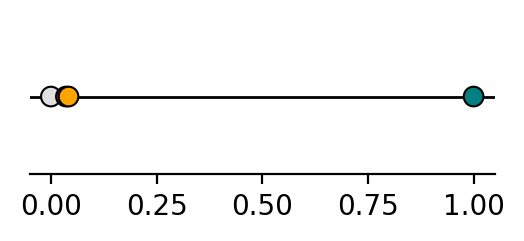

In [18]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 1

pdf = cdf.copy()

colors = [
    '#e0e0e0',    # Brighter light gray    
    '#DC143C',   # Crimson red/

    '#FFA500',    # Bright orange 
    '#008080',    # Vivid teal
    
]

sns.scatterplot(
    data=pdf,
    x='x_scaled',
    y=0.0,
    hue='label',
    marker='o',
    ec='k',
    lw=0.75,
    s=50,
    palette=colors,
    legend=False,
)

plt.axhline(y=0, zorder=0, lw=1, c='k')

sns.despine(left=True)
plt.yticks([])
plt.ylim([-0.01, 0.01])
plt.xlabel('')
plt.gcf().patch.set_facecolor('none')
plt.gca().patch.set_facecolor('none')

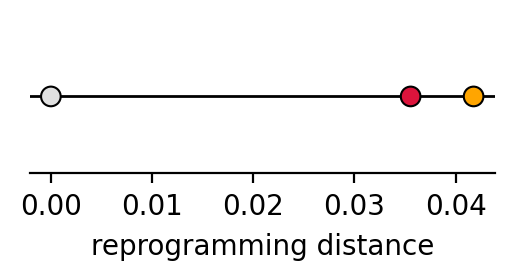

In [19]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 1

pdf = cdf.copy()
pdf = pdf[pdf['label'] != 'HSC']


sns.scatterplot(
    data=pdf,
    x='x_scaled',
    y=0.0,
    hue='label',
    marker='o',
    ec='k',
    lw=0.75,
    s=50,
    palette=colors,
    legend=False,
)

plt.axhline(y=0, zorder=0, lw=1, c='k')

sns.despine(left=True)
plt.yticks([])
plt.ylim([-0.01, 0.01])
plt.xlabel('reprogramming distance')
plt.gcf().patch.set_facecolor('none')
plt.gca().patch.set_facecolor('none')

In [20]:
# break

# Sample MDS

In [21]:
adata.obs['group2'].value_counts()

group2
HSC       18302
Bj Fib     7315
C1         3834
C2         1650
C3         1497
C4          558
C5           20
Name: count, dtype: int64

In [22]:
adata.obs['group'].value_counts()

group
HSC          18302
BJ Fib        7873
iHSC-low      5331
iHSC-high     1670
Name: count, dtype: int64

group
BJ Fib       250
HSC          250
iHSC-high    250
iHSC-low     250
Name: count, dtype: int64
X.shape=(1000, 13000)
A.shape=(1000, 1000)
coordinates.shape=(1000, 2)


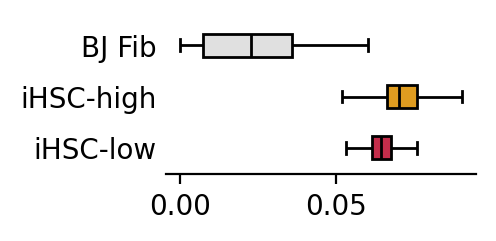

In [27]:
metric = 'cosine'
n = 250

# Sample n items from each group
sampled_df = adata.obs.groupby('group').apply(lambda x: x.sample(n=n, replace=False))
sampled_df = sampled_df.reset_index(level='group', drop=True)

print(sampled_df['group'].value_counts())

sample_idx = sampled_df.index
X = adata[sample_idx,].layers['scaled_scanvi']
print(f"{X.shape=}")

A = squareform(pdist(X, metric=metric))
A = pd.DataFrame(
    A,
    index=sampled_df.index,
    columns=sampled_df.index,
)

print(f"{A.shape=}")

mds = MDS(n_components=2, dissimilarity='precomputed')
coordinates = mds.fit_transform(A)
print(f"{coordinates.shape=}")

cdf = pd.DataFrame({
    'x' : coordinates[:, 0],
    'x_scaled' : scaler(coordinates[:, 0]),
    'group' : sampled_df['group'].values,
    'group2' : sampled_df['group2'].values,
})

cdf = cdf.sort_values(by='group')
cdf['group'] = cdf['group'].astype(str)
cdf = cdf[cdf['group'] != 'HSC']

cdf.head()

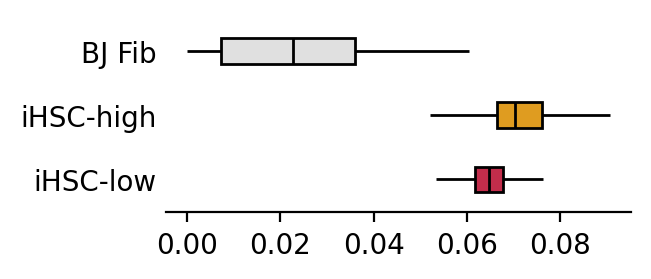

In [34]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 1.25

sns.boxplot(
    data=cdf,
    x='x_scaled',
    y='group',
    hue='group',
    linecolor='k',
    width=0.4,
    hue_order=['BJ Fib', 'iHSC-low', 'iHSC-high'],
    palette=colors,
    showcaps=False,
    showfliers=False, 
)

# plt.yticks([])
plt.tick_params(axis='y', which='both', length=0) 

plt.ylabel("")
plt.xlabel("")

sns.despine(left=True)

In [24]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

X.shape=(1000, 13000)
A.shape=(1000, 1000)
coordinates.shape=(1000, 2)


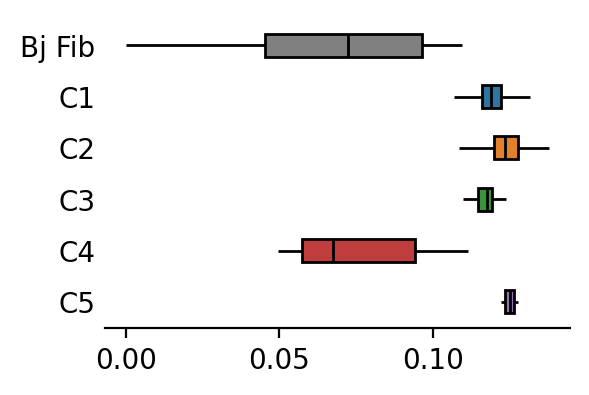

In [36]:
metric = 'cosine'
n = 250

# Sample n items from each group
sampled_df = adata.obs.groupby('group').apply(lambda x: x.sample(n=n, replace=False))
sampled_df = sampled_df.reset_index(level='group', drop=True)

sample_idx = sampled_df.index
X = adata[sample_idx,].layers['scaled_scanvi']
print(f"{X.shape=}")

A = squareform(pdist(X, metric=metric))
A = pd.DataFrame(
    A,
    index=sampled_df.index,
    columns=sampled_df.index,
)

print(f"{A.shape=}")

mds = MDS(n_components=2, dissimilarity='precomputed')
coordinates = mds.fit_transform(A)
print(f"{coordinates.shape=}")

cdf = pd.DataFrame({
    'x' : coordinates[:, 0],
    'x_scaled' : scaler(coordinates[:, 0]),
    'group' : sampled_df['group'].values,
    'group2' : sampled_df['group2'].values,
})

cdf = cdf.sort_values(by='group2')
cdf['group'] = cdf['group'].astype(str)
cdf['group2'] = cdf['group2'].astype(str)
cdf = cdf[cdf['group'] != 'HSC']
cdf.head()



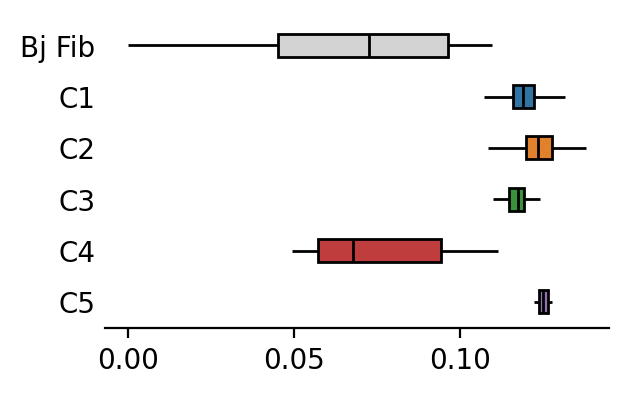

In [40]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.25, 2

sns.boxplot(
    data=cdf,
    x='x_scaled',
    y='group2',
    hue='group2',
    linecolor='k',
    width=0.45,
    palette=['lightgrey', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'],
    showcaps=False,
    showfliers=False, 
)

# plt.yticks([])
plt.tick_params(axis='y', which='both', length=0) 

plt.ylabel("")
plt.xlabel("")

sns.despine(left=True)

In [ ]:
break

# expression and distance

In [41]:
metric = 'cosine'
n = 500

# Sample n items from each group
sampled_df = adata.obs.groupby('group').apply(lambda x: x.sample(n=n, replace=False))
sampled_df = sampled_df.reset_index(level='group', drop=True)

sample_idx = sampled_df.index
X = adata[sample_idx,].layers['scaled_scanvi']
print(f"{X.shape=}")

A = squareform(pdist(X, metric=metric))
A = pd.DataFrame(
    A,
    index=sampled_df.index,
    columns=sampled_df.index,
)

print(f"{A.shape=}")

mds = MDS(n_components=2, dissimilarity='precomputed')
coordinates = mds.fit_transform(A)
print(f"{coordinates.shape=}")

cdf = pd.DataFrame({
    'x' : coordinates[:, 0],
    'x_scaled' : scaler(coordinates[:, 0]),
    'group' : sampled_df['group'].values,
    'group2' : sampled_df['group2'].values,
})

cdf['group'] = cdf['group'].astype(str)
cdf['group2'] = cdf['group2'].astype(str)

cdf.groupby('group')['x_scaled'].mean()

X.shape=(2000, 13000)
A.shape=(2000, 2000)
coordinates.shape=(2000, 2)


group
BJ Fib       0.946448
HSC          0.024313
iHSC-high    0.906230
iHSC-low     0.913098
Name: x_scaled, dtype: float64

In [42]:
result = []

exp_df = adata[sample_idx, :].to_df(layer='scaled_scanvi')
print(f"{exp_df.shape=}")

for gene in exp_df.columns:
    r, pval = scipy.stats.pearsonr(cdf['x_scaled'], exp_df[gene])
    row = df.loc[gene].to_dict()

    score = (row['iHSC-high'] - row['BJ Fib']) / (row['iHSC-high'] - row['HSC'])
    row['score'] = score
    row['gene_name'] = gene
    row['correlation'] = r
    row['p_value'] = pval
    result.append(row)

result = pd.DataFrame(result)
result = result.sort_values(by='score', ascending=False)
result.head(25)

exp_df.shape=(2000, 13000)


,BJ Fib,HSC,iHSC-high,iHSC-low,score,gene_name,correlation,p_value
2288,0.080482,0.139420,0.139437,0.131082,3416.792931,CMPK2,-0.369745,7.983255e-66
7050,0.127067,0.190250,0.190420,0.177889,372.578873,NEDD9,-0.358792,8.073181e-62
5743,0.053685,0.095299,0.095537,0.088400,176.265849,LACTB2-AS1,-0.358594,9.505010e-62
6228,0.095744,0.166565,0.166998,0.157023,164.555902,MAP3K9,-0.362768,2.960723e-63
10390,0.257515,0.304671,0.304973,0.295422,157.518539,SNX32,-0.277591,1.035934e-36
289,0.062891,0.093073,0.093300,0.089621,133.970091,AFAP1L1,-0.309747,9.954939e-46
10337,0.041743,0.075697,0.076006,0.067045,110.945725,SMTNL1,-0.413413,2.074951e-83
6323,0.091570,0.173720,0.174500,0.157245,106.353710,MCM8,-0.382663,9.437865e-71
5459,0.023365,0.052254,0.052571,0.046849,92.116663,KCNRG,-0.387683,9.978878e-73
12224,0.230120,0.396106,0.398120,0.371058,83.440793,WASF3,-0.376124,3.139726e-68


In [43]:
outpath = '../../../temp/mds_distance_correlation.csv'
result.to_csv(outpath, index=False)
result.head(10)

,BJ Fib,HSC,iHSC-high,iHSC-low,score,gene_name,correlation,p_value
2288,0.080482,0.139420,0.139437,0.131082,3416.792931,CMPK2,-0.369745,7.983255e-66
7050,0.127067,0.190250,0.190420,0.177889,372.578873,NEDD9,-0.358792,8.073181e-62
5743,0.053685,0.095299,0.095537,0.088400,176.265849,LACTB2-AS1,-0.358594,9.505010e-62
6228,0.095744,0.166565,0.166998,0.157023,164.555902,MAP3K9,-0.362768,2.960723e-63
10390,0.257515,0.304671,0.304973,0.295422,157.518539,SNX32,-0.277591,1.035934e-36
289,0.062891,0.093073,0.093300,0.089621,133.970091,AFAP1L1,-0.309747,9.954939e-46
10337,0.041743,0.075697,0.076006,0.067045,110.945725,SMTNL1,-0.413413,2.074951e-83
6323,0.091570,0.173720,0.174500,0.157245,106.353710,MCM8,-0.382663,9.437865e-71
5459,0.023365,0.052254,0.052571,0.046849,92.116663,KCNRG,-0.387683,9.978878e-73
12224,0.230120,0.396106,0.398120,0.371058,83.440793,WASF3,-0.376124,3.139726e-68


In [46]:
reload(ut)
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

pathway = 'Hematopoietic Stem Cells'
# pathway = 'Fibroblasts'
query_genes = list(features[features[pathway]].index)
query_genes = [x for x in query_genes if x in adata.var_names]

result[result['gene_name'].isin(query_genes)].sort_values(by='score', ascending=False).head(25)

,BJ Fib,HSC,iHSC-high,iHSC-low,score,gene_name,correlation,p_value
6694,0.025776,0.052827,0.057252,0.051574,7.112287,MS4A6A,-0.255556,3.455199e-31
1786,0.049015,0.057666,0.059374,0.054266,6.064410,CD14,-0.143066,1.299685e-10
6570,0.112806,0.150239,0.157948,0.147256,5.855636,MNDA,-0.180945,3.507721e-16
9200,0.343391,0.496956,0.547833,0.523145,4.018373,RGS18,-0.125505,1.786282e-08
9903,0.021505,0.038391,0.044431,0.038167,3.795468,SIGLEC1,-0.193959,2.097362e-18
1299,0.016957,0.026044,0.030304,0.026441,3.132852,C1QA,-0.098533,1.012267e-05
3906,0.083039,0.133341,0.157830,0.141851,3.054061,FGL2,-0.102186,4.670881e-06
7760,0.094667,0.111648,0.122306,0.115958,2.593326,P2RY13,-0.036539,1.023455e-01
2217,0.043535,0.068331,0.085936,0.079915,2.408432,CLEC14A,-0.009413,6.739665e-01
11217,0.024671,0.030676,0.062295,0.055462,1.189901,TLR8,0.379595,1.464305e-69


In [47]:
result.sort_values(by='score', ascending=False).head(25)

,BJ Fib,HSC,iHSC-high,iHSC-low,score,gene_name,correlation,p_value
2288,0.080482,0.139420,0.139437,0.131082,3416.792931,CMPK2,-0.369745,7.983255e-66
7050,0.127067,0.190250,0.190420,0.177889,372.578873,NEDD9,-0.358792,8.073181e-62
5743,0.053685,0.095299,0.095537,0.088400,176.265849,LACTB2-AS1,-0.358594,9.505010e-62
6228,0.095744,0.166565,0.166998,0.157023,164.555902,MAP3K9,-0.362768,2.960723e-63
10390,0.257515,0.304671,0.304973,0.295422,157.518539,SNX32,-0.277591,1.035934e-36
289,0.062891,0.093073,0.093300,0.089621,133.970091,AFAP1L1,-0.309747,9.954939e-46
10337,0.041743,0.075697,0.076006,0.067045,110.945725,SMTNL1,-0.413413,2.074951e-83
6323,0.091570,0.173720,0.174500,0.157245,106.353710,MCM8,-0.382663,9.437865e-71
5459,0.023365,0.052254,0.052571,0.046849,92.116663,KCNRG,-0.387683,9.978878e-73
12224,0.230120,0.396106,0.398120,0.371058,83.440793,WASF3,-0.376124,3.139726e-68


In [ ]:
break

In [ ]:
reload(ut)
fpath = "../resources/GO_Biological_Process_2023.txt"
features = ut.load_pathway(fpath)

pways = [x for x in features.columns if 'hemato' in x.lower()]
print(pways)

In [ ]:
pathway = "Hematopoietic Stem Cell Differentiation (GO:0060218)"
# pathway = "Hematopoietic Stem Cell Proliferation (GO:0071425)"
query_genes = list(features[features[pathway]].index)
query_genes = [x for x in query_genes if x in adata.var_names]
print(query_genes)

pdf = result[result['gene_name'].isin(query_genes)].copy()

pdf['BJ Fib'] =  pdf['BJ Fib'] / pdf['HSC']
pdf['iHSC-high'] =  pdf['iHSC-high'] / pdf['HSC']
pdf['iHSC-low'] =  pdf['iHSC-low'] / pdf['HSC']

pdf = pd.melt(
    pdf, 
    id_vars=['gene_name'],
    value_vars=['BJ Fib', 'iHSC-high', 'iHSC-low'],
)

pdf = pdf.sort_values(by='variable')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2

sns.barplot(
    data=pdf,
    x='gene_name',
    y='value',
    hue='variable',
    palette=['grey', '#d04c00', '#9309dd',],
    width=0.45,
    ec='k'
)

plt.axhline(y=1)
plt.gca().tick_params(axis='x', rotation=90)
sns.despine()


In [ ]:
break

In [ ]:
n_genes = 10
# database = 'ontology'
database = 'PanglaoDB_Augmented_2021'

pdf = result.copy()
pdf = pdf.sort_values(by='correlation', ascending=False)
edf = gget.enrichr(pdf['gene_name'].head(n_genes), database=database)

edf[['path_name', 'adj_p_val', 'overlapping_genes']].head()


In [ ]:
result = result.sort_values(by='score', ascending=False)
result.head(25)

In [ ]:
break

In [ ]:
reload(ut)
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

pways = [x for x in features.columns if 'hemato' in x.lower()]
print(pways)

pathway = 'Hematopoietic Stem Cells'
# pathway = 'Fibroblasts'
query_genes = list(features[features[pathway]].index)
query_genes = [x for x in query_genes if x in adata.var_names]

result[result['gene_name'].isin(query_genes)].tail(25)

In [ ]:
result[result['gene_name'].isin(query_genes)].head(15)

In [ ]:
break

In [ ]:
metric = 'cosine'
# n = 250

# # Sample n items from each group
# sampled_df = adata.obs.groupby('group').apply(lambda x: x.sample(n=n, replace=False))
# sampled_df = sampled_df.reset_index(level='group', drop=True)

# print(sampled_df['group'].value_counts())

# sample_idx = sampled_df.index
X = adata.layers['scaled_scanvi']
print(f"{X.shape=}")

A = squareform(pdist(X, metric=metric))
A = pd.DataFrame(
    A,
    index=sampled_df.index,
    columns=sampled_df.index,
)

print(f"{A.shape=}")

# mds = MDS(n_components=2, dissimilarity='precomputed')
# coordinates = mds.fit_transform(A)
# print(f"{coordinates.shape=}")

# cdf = pd.DataFrame({
#     'x' : coordinates[:, 0],
#     'x_scaled' : scaler(coordinates[:, 0]),
#     'group' : sampled_df['group'].values,
#     'group2' : sampled_df['group2'].values,
# })

# cdf = cdf.sort_values(by='group')
# cdf['group'] = cdf['group'].astype(str)
# print(f"{cdf.shape=}")
# cdf.head()

# Archive

In [ ]:
break